<h1 style="text-align:center">Airborne Object Tracking - CNN Model
</h1>

####Accessing the dataset involved the following code that was referenced in the AOT challenge website: https://www.aicrowd.com/challenges/airborne-object-tracking-challenge and with the tutorial code created by Vuong Tuan Khanh at: https://github.com/VuongTuanKhanh/Airborne-Object-Detection-and-Tracking
Helper script for easy access the dataset: https://gitlab.aicrowd.com/amazon-prime-air/airborne-detection-starter-kit/-/blob/master/docs/DATASET.md  
Dataset is hosted on a public AWS S3: s3://airborne-obj-detection-challenge-training/

# Imports

In [1]:
import json
import random
import os, sys
from IPython.display import display, clear_output, HTML
from random import randrange, choice
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
import numpy as np
import seaborn as sns

random.seed(42)

def mdprint(text):
    display({
        'text/markdown': text,
        'text/plain': text
    }, raw=True)

!git clone https://github.com/VuongTuanKhanh/Funix-Capstone-Project.git

os.mkdir("Funix-Capstone-Project/data")
os.chdir("Funix-Capstone-Project/data")

Cloning into 'Funix-Capstone-Project'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 528 (delta 2), reused 2 (delta 0), pack-reused 519
Receiving objects: 100% (528/528), 406.22 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (167/167), done.
Updating files: 100% (172/172), done.


## Loading Dataset (Part 1 only)

In [2]:
# Dataset for Airborne Object Tracking Dataset
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())) + "/core")

!pip install -r ../requirements.txt > /dev/null

from core.dataset import Dataset
notebook_path = os.path.dirname(os.path.realpath("__file__"))

local_path = notebook_path + '/part1'
s3_path = 's3://airborne-obj-detection-challenge-training/part1/'
dataset = Dataset(local_path, s3_path, partial=True, prefix='part1')
dataset.add(local_path, s3_path)

2024-08-04 20:04:38.078 | INFO     | core.dataset:load_ve:57 - Loading valid encounters...
2024-08-04 20:04:38.082 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.json
2024-08-04 20:04:39.066 | INFO     | core.dataset:load_gt:28 - Loading ground truth...
2024-08-04 20:04:39.070 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: ImageSets/groundtruth.json
2024-08-04 20:04:55.565 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present in valid encounters: 673f29c3e4b4428fa26bc55d812d45d9
2024-08-04 20:04:55.602 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present in valid encounters: 63c5597a57b04b448723f1f1844a2b78
2024-08-04 20:04:55.610 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present in valid encounters: 4458bb328345402c8f363b7480060393
2024-08-04 20

## Ground Truth Structure

In [3]:
# Keys
def remove_numbers(s):
  return ''.join([i for i in s if not i.isdigit()])

all_keys = []
for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    all_keys.extend([remove_numbers(k) for k in flight.detected_objects])

unique_keys = list(set(all_keys))
unique_keys

['Drone', 'Airplane', 'Flock', 'Airborne', 'Bird', 'Helicopter']

## Loading dataset as a Pandas df

In [4]:
rows = []
for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj_key in flight.detected_objects:
        object_type = remove_numbers(obj_key)
        obj = flight.detected_objects[obj_key]
        for loc in obj.location:
            bbox = loc.bb.get_bbox()
            frame_id = loc.frame.id
            range_distance = loc.range_distance_m
            image_path = loc.frame.image_path()
            rows.append([flight_id, object_type, obj_key, frame_id,
                         *bbox, bbox[-1]*bbox[-2], image_path, range_distance])

In [5]:
import pandas as pd
# converting the rows array to a dataframe
df = pd.DataFrame(rows)
df.columns = ['flight_id', 'object_type', 'object', 'frame_id',
              'left', 'top', 'width', 'height', 'area', 'image_path','range_distance']
df.head()

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
0,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,105,1414.4,1180.0,27.0,7.2,194.40,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,699.080159
1,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,106,1416.6,1174.8,28.6,6.6,188.76,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,692.630062
2,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,107,1417.4,1171.4,29.2,7.6,221.92,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,686.419015
3,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,108,1418.8,1172.4,28.8,7.0,201.60,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,679.760444
4,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,109,1422.0,1167.4,29.4,6.8,199.92,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,673.387413


## Download images for training

In [6]:
#Filter data points by objects and pick objects larger than a certain value.
import random
filtered_df = df.loc[((df['object_type'] == 'Helicopter') | (df['object_type'] == 'Airplane') |
              (df['object_type'] == 'Flock') | (df['object_type'] == 'Bird')
              | (df['object_type'] == 'Airborne') | (df['object_type'] == 'Drone'))]
filtered_df = filtered_df.loc[df['area'] > 200]

flights = filtered_df.index[(filtered_df['object_type'] == 'Airplane')]
helicopters = filtered_df.index[(filtered_df['object_type'] == 'Helicopter')]
flocks = filtered_df.index[(filtered_df['object_type'] == 'Flock')]
birds = filtered_df.index[(filtered_df['object_type'] == 'Bird')]
airbornes = filtered_df.index[(filtered_df['object_type'] == 'Airborne')]
drones = filtered_df.index[(filtered_df['object_type'] == 'Drone')]

counts_dict = dict(filtered_df['image_path'].value_counts())
multi_object_frames = filtered_df[filtered_df.apply(lambda x:counts_dict[x['image_path']] > 1, axis=1)].index
train_indices = (random.sample(list(flights),2000) +
                 random.sample(list(helicopters),2000) +
                random.sample(list(flocks),900) +
                 random.sample(list(birds),1000) +
                 random.sample(list(airbornes),2000) +
                 random.sample(list(drones),200))
train_df = filtered_df.loc[list(set(train_indices))]
filtered_df.head()

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
2,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,107,1417.4,1171.400000,29.200000,7.600000,221.920000,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,686.419015
3,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,108,1418.8,1172.400000,28.800000,7.000000,201.600000,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,679.760444
5,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,110,1424.0,1166.000000,30.000000,8.200000,246.000000,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,667.194772
6,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,111,1425.0,1165.400000,29.800000,9.400000,280.120000,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,660.494085
7,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,112,1430.2,1162.722046,31.214185,8.482666,264.779502,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,654.149399


In [7]:
download_images = []
for idx in range(len(train_df)):
  flight = dataset.flights[train_df.iloc[idx]['flight_id']]
  frame = flight.frames[train_df.iloc[idx]['frame_id']]
  image_path = frame.image_path()
  s3_path = frame.image_s3_path()
  download_images.append([image_path, image_path])
random.shuffle(download_images)

from tqdm import tqdm
for idx in tqdm(range(500)):
  dataset.file_handler.download_from_s3_parallel(download_images[idx])

100%|██████████| 500/500 [06:16<00:00,  1.33it/s]


#CNN

In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import os
import glob

In [9]:
#Create subfolders for classes and place images into corresponding folders
os.mkdir('/content/Dataset')
os.mkdir('/content/Dataset/Airplane')
os.mkdir('/content/Dataset/Helicopter')
os.mkdir('/content/Dataset/Flock')
os.mkdir('/content/Dataset/Bird')
os.mkdir('/content/Dataset/Airborne')
os.mkdir('/content/Dataset/Drone')

In [10]:
folders = os.listdir('/content/Funix-Capstone-Project/data/part1/Images')
labels = []
for i in folders:
  indices = np.where(filtered_df['flight_id'] == i)
  index = indices[0][0]
  label = filtered_df['object_type'].iloc[index]
  labels.append(label)

labels = pd.DataFrame(labels,columns=['class'])
labels['image'] = folders

In [11]:
for i in range(0,len(folders)):
  class_name = labels['class'].iloc[i]
  folder_name = labels['image'].iloc[i]
  x = glob.glob('/content/Funix-Capstone-Project/data/part1/Images/'+folder_name+'/*')
  for a in x:
    name = os.path.split(a)
    y = '/content/Dataset/'+class_name+'/'+name[1]
    os.rename(a,y)

In [12]:
pip install split-folders

In [13]:
#Split data into training, validation, and testing datasets
import splitfolders
output = '/content/Data'

splitfolders.ratio('/content/Dataset', output=output, seed=42, ratio=(.7, .2, .1))

Copying files: 496 files [00:06, 81.20 files/s]


In [14]:
#Import datasets, convert to grayscale, and resize to (32,32)
train_dir = '/content/Data/train'
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, labels="inferred",
                                                                 label_mode="categorical",color_mode='grayscale',
                                                                 image_size=(32, 32))
test_dir = '/content/Data/test'
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, labels="inferred",
                                                                label_mode="categorical",color_mode='grayscale',
                                                                image_size=(32, 32))
val_dir = '/content/Data/val'
val_data = tf.keras.utils.image_dataset_from_directory(val_dir, labels="inferred",
                                                               label_mode="categorical",color_mode='grayscale',
                                                               image_size=(32, 32))

Found 345 files belonging to 6 classes.
Found 55 files belonging to 6 classes.
Found 96 files belonging to 6 classes.


In [15]:
#Create CNN model
preprocessing_layers = [
    tf.keras.layers.Rescaling(1./255, input_shape=(32,32,1))
]

def conv_2d_pooling_layers(filters):
    return [
        tf.keras.layers.Conv2D(
            filters,
            kernel_size=(3,3),
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]

core_layers = \
    conv_2d_pooling_layers(16)

dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6)
]

model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          24,582 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,742 (96.65 KB)

 Trainable params: 24,742 (96.65 KB)

 Non-trainable params: 0 (0.00 B)

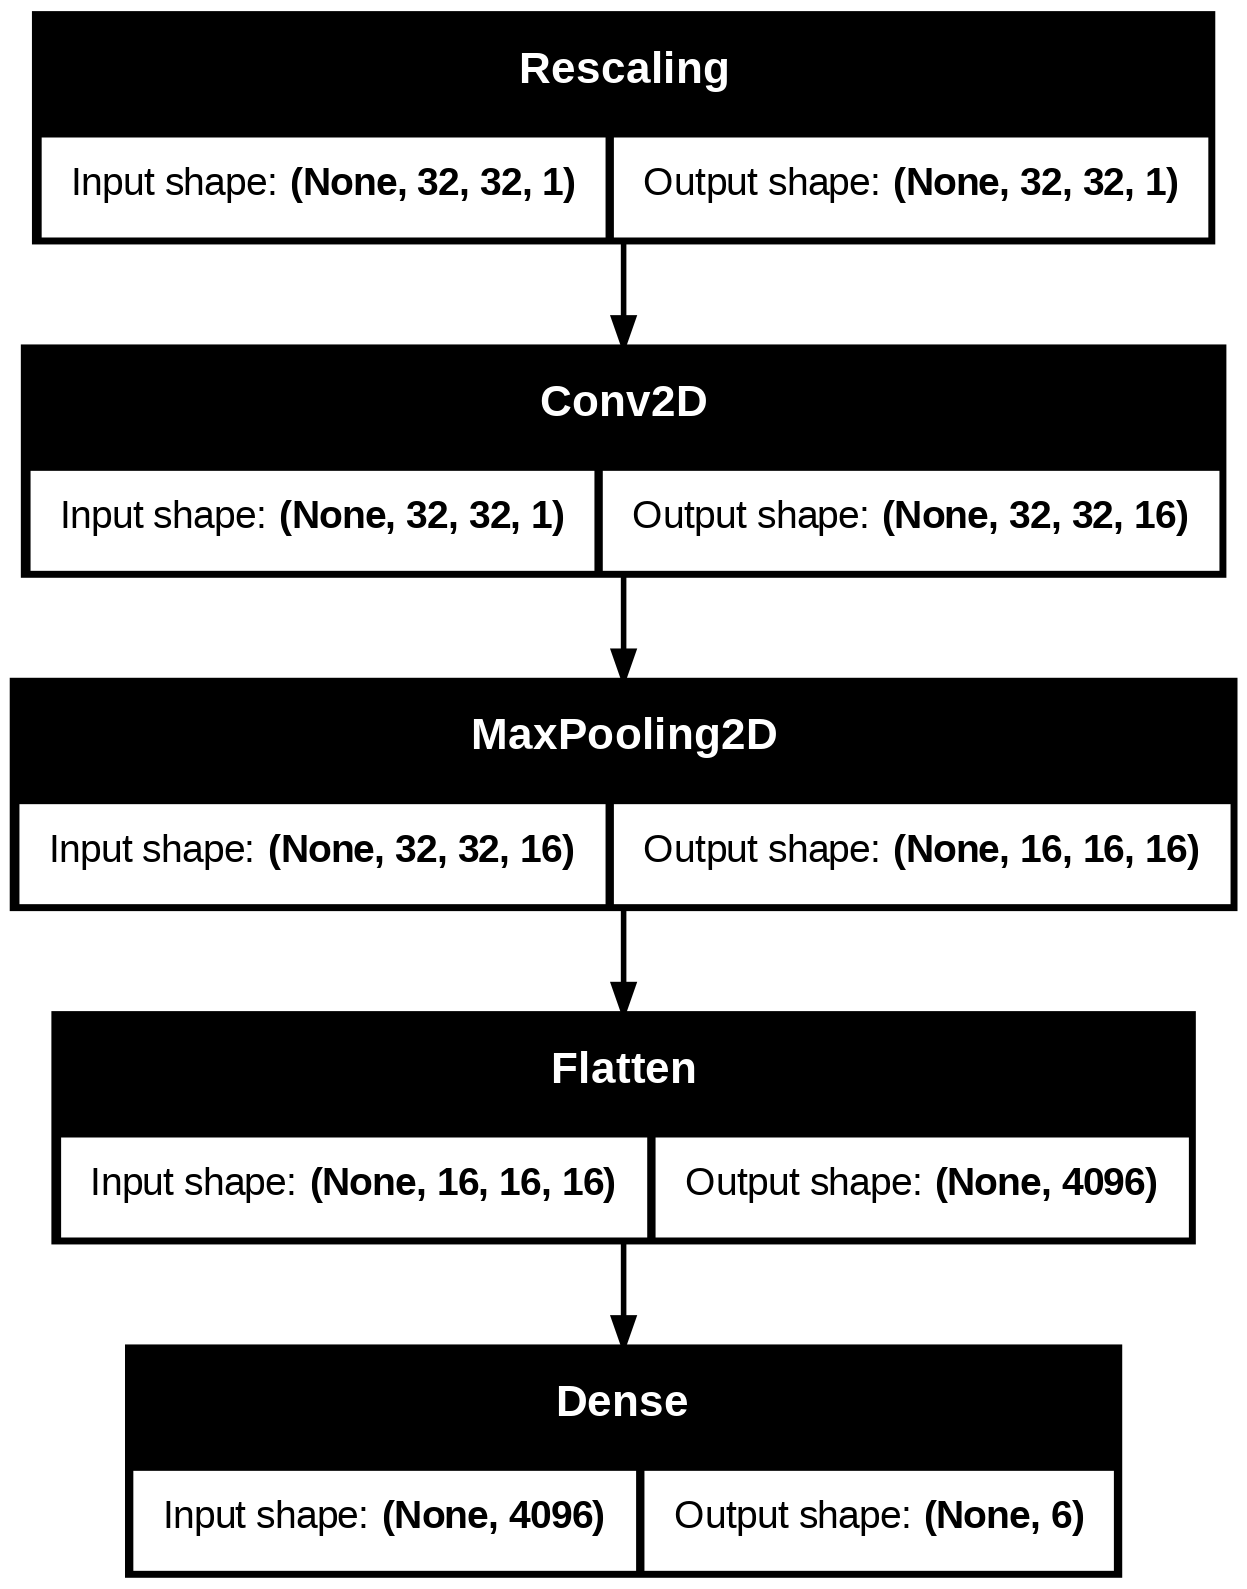

In [16]:
#Visualize model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

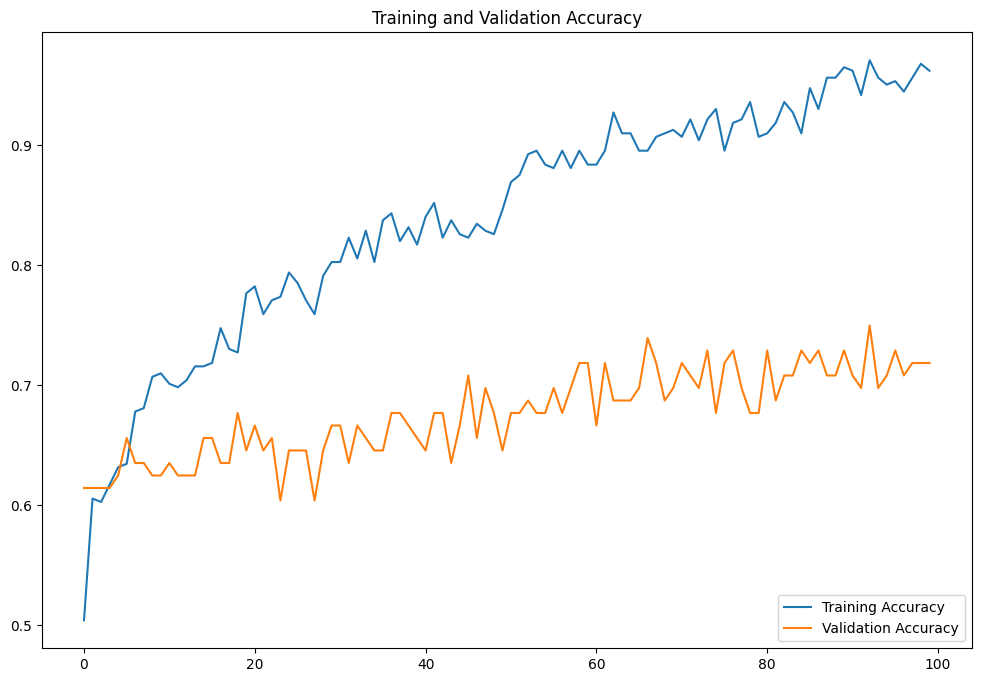

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6875 - loss: 0.8677 - precision: 0.4514 - recall: 0.8737


[0.8159038424491882, 0.71875, 0.4648648500442505, 0.8958333134651184]

In [17]:
#Evaluate model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

history = model.fit(train_data, epochs=100, validation_data=val_data,verbose=0)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

model.evaluate (val_data)

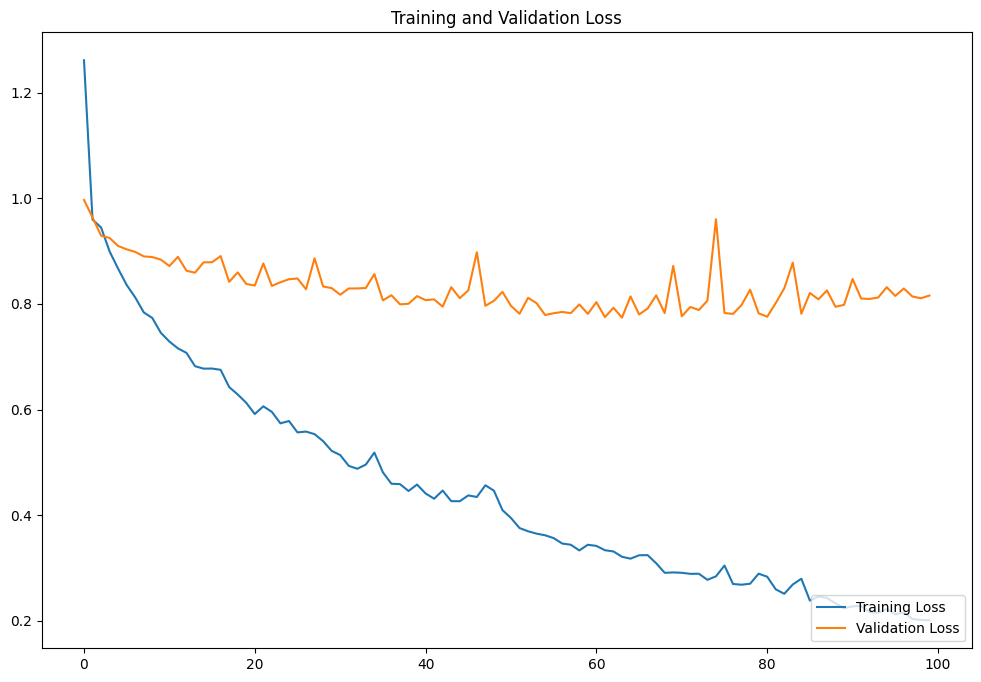

In [18]:
#Plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
#Evaluate on test dataset
model.evaluate (test_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7366 - loss: 0.8929 - precision: 0.4304 - recall: 0.8527


[0.8370252251625061,
 0.7454545497894287,
 0.4324324429035187,
 0.8727272748947144]